In [1]:
using JLD
using HDF5
using Dates
using PyCall
using Random
using PyPlot
using Plots
using StatsBase
using Statistics
using BenchmarkTools
using DataFrames, IndexedTables
using Flux: onehot, onehotbatch, softmax, sigmoid
using BSON: @load, @save

system = "free_flyer"
include("$system/problem.jl")
include("$system/strategy_utils.jl")
include("$system/utils.jl")
include("$system/models.jl")
include("fileIO.jl");

In [2]:
ENV["CUDA_VISIBLE_DEVICES"] = "0"

pushfirst!(PyVector(pyimport("sys")."path"), @__DIR__) #need this to be able to source from pytorch.models
torch = pyimport("torch")
torch.cuda.empty_cache()
torchvision = pyimport("torchvision")
np = pyimport("numpy")
sns = pyimport("seaborn")

FFNet = pyimport("pytorch.models")."FFNet" #import custom nn class
BnBCNN = pyimport("pytorch.models")."BnBCNN"

PyObject <class 'pytorch.models.BnBCNN'>

In [3]:
prob_files = [string("$system/data/testdata",ii,".jld") for ii=1:20] #filenames, choose 1-16 for training
prob_dicts = [load(f) for f in prob_files]

# Set problem specific features
prob_features = ["X0",  "obstacles"]

N = 6
n_obs = 8

# Calculate length of feature vector
feature_size = 0
if "X0" in prob_features
  feature_size += 4
end
if "obstacles" in prob_features
  feature_size += 4*n_obs
end
if "obstacles_map" in prob_features
  feature_size += n_obs*W*H
end
feature_size = Int(feature_size+=n_obs)

# Optimization problem handle
prob_handle = getObstacleAvoidanceProb

depth = 3
neurons = 128

training_percentage = 0.9
training_batch_length = Int(round(training_percentage*length(prob_dicts)));

# Identify possible strategies

In [ ]:
strategy_dict = Dict{Array{Int64,1}, Array{Int64,1}}()
training_labels = Dict{Array{Float64,1}, Array{Int64,1}}()

N_strategies = 0
for dir_idx in 1:training_batch_length
  for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
    y_true = Int.(round.(prob_dicts[dir_idx]["Y"][prob_idx]'[:]))
    Y_true = Int.(round.(prob_dicts[dir_idx]["Y"][prob_idx]))

    obs_strats = which_M(prob_dicts,dir_idx,prob_idx)

    for (ii_obs,obs_strat) in enumerate(obs_strats)
        if !haskey(strategy_dict,obs_strat)
            # Strategy unseen    
            N_strategies += 1

            strategy = [N_strategies; 
                    vectorizeIntegerData(Y_true[4*(ii_obs-1)+1:4*ii_obs,:])]
            strategy_dict[obs_strat] = strategy
        end

        prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
        features = [onehot(ii_obs, 1:n_obs);
                construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)]

        training_labels[features] = strategy_dict[obs_strat]
    end
  end
end

N_strategies

In [ ]:
X = zeros(Float64,feature_size,length(keys(training_labels)))
Y = zeros(Int64,4*(N-1)+1,length(keys(training_labels)))

for (key_ct,v) in enumerate(training_labels)
    X[:,key_ct] = v[1]
    Y[:,key_ct] = v[2]
end

In [ ]:
frequencies = zeros(Int64,N_strategies)
for ii in 1:N_strategies
    frequencies[ii] = sum(ii .== Y[1,:])
end
Plots.plot(1:N_strategies, frequencies, title="Count for i-th strategy")

In [ ]:
fn_model = string("models/mlopt_model_","$(system)_",Dates.format(DateTime(Dates.now()), "yyyymmdd_HHMM"), "_$(depth)-layers_$(neurons)-neurons.jld")

save(fn_model, "system", system, "N_strategies", N_strategies, "feature_size", feature_size,
    "X", X, "Y", Y, "strategy_dict", strategy_dict, "prob_features", prob_features)
    # "W", W, "H", H, "channels", channels)

In [ ]:
strategy_dict = Dict{Array{Int64,1}, Array{Int64,1}}()
training_labels = Dict{Array{Float64,1}, Array{Int64,1}}()

N_strategies = 0
for dir_idx in 1:training_batch_length
  for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
    y_true = vectorizeIntegerData(prob_dicts[dir_idx]["Y"][prob_idx])

    if !haskey(strategy_dict,y_true)
        # Strategy unseen
        N_strategies += 1
        strategy_dict[y_true] = [N_strategies; y_true]
    end

    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)

    training_labels[features] = strategy_dict[y_true]
  end
end

N_strategies

X = zeros(Float64,Int(feature_size-n_obs),length(keys(training_labels)))
Y = zeros(Int64,4*n_obs*(N-1)+1,length(keys(training_labels)))

for (key_ct,v) in enumerate(training_labels)
    X[:,key_ct] = v[1]
    Y[:,key_ct] = v[2]
end

fn_model = string("models/mlopt_model_naive_","$(system)_",Dates.format(DateTime(Dates.now()), "yyyymmdd_HHMM"), "_$(depth)-layers_$(neurons)-neurons.jld")

save(fn_model, "system", system, "N_strategies", N_strategies, "feature_size", feature_size-n_obs,
    "X", X, "Y", Y, "strategy_dict", strategy_dict, "prob_features", prob_features);

# Train model from terminal
Run `python train_classifier.py ../model/{fn_model}.jld` from the `pytorch` directory
This step will generate a `{fn_model}.pt` parameter file that will get loaded and used for evaluation in the next section

In [76]:
fn_model = "models/mlopt_model_free_flyer_20200406_0927_3-layers_128-neurons.jld"
fn_dict = load(fn_model)
feature_size = fn_dict["feature_size"]
N_strategies = fn_dict["N_strategies"]
strategy_dict = fn_dict["strategy_dict"];

# Evaluate naive classification model

In [4]:
fn_model = "models/mlopt_model_naive_free_flyer_20200406_0928_3-layers_128-neurons.jld"
fn_dict = load(fn_model)
feature_size = fn_dict["feature_size"]
N_strategies = fn_dict["N_strategies"]
strategy_dict = fn_dict["strategy_dict"];

naive_classifier_fn = replace(fn_model, ".jld"=>"_classifier.pt")
naive_classifier_model = get_ff_classifier(feature_size, N_strategies; depth=depth,neurons=neurons)
naive_classifier_model.load_state_dict(torch.load(naive_classifier_fn))
n_evals = 16;

In [5]:
function solve_with_naive_classifier(prob, prob_dicts, dir_idx, prob_idx, n_evals)    
    # Construct problem object
    y_binary = all_variables(prob)[is_binary.(all_variables(prob))]
    unset_binary.(y_binary) #relax so we solve LPs

    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)
    input = torch.from_numpy(reshape(features,1,feature_size)).float()

    # Grab the n_evals-best strategies for this problem
    solve_time = @elapsed begin
        scores = naive_classifier_model(input).cpu().detach().numpy()[:];
    end
    ind_max = partialsortperm(scores, 1:n_evals, rev=true)

    # Get integer assignments for each obstacle
    y_strats = [Array{Int64,1}() for _ in 1:n_evals]
    # Search through strategy dictionary to find the strategy
    # corresponding to classifier output
    for (k,v) in enumerate(strategy_dict)
        for (ii,ind) in enumerate(ind_max)
            # First element of value will be index
            if ind == v[2][1]
                # Grab binary values for this strategy
                y_strats[ii] = v[2][2:end]
            end
        end
    end

    for (ii_eval,ind) in enumerate(ind_max)
        # y_guess = zeros(Int,length(y_binary))
        y_guess = y_strats[ii_eval]
        fix.(y_binary,round.(y_guess), force=true)

        original_stdout = stdout
        (read_pipe, write_pipe) = redirect_stdout()
        optimize!(prob)
        redirect_stdout(original_stdout)
        close(write_pipe)
        solve_time += MOI.get(prob, MOI.SolveTime())

        if termination_status(prob) == MOI.OPTIMAL
            return true, objective_value(prob), solve_time, ii_eval
        end
        unfix.(y_binary)
    end
    return false, Inf, solve_time, n_evals
end

solve_with_naive_classifier (generic function with 1 method)

In [6]:
costs_naive_classifier = Float64[]
costs_ratios_naive_classifier = Float64[]
solve_times_naive_classifier = Float64[]
num_solves_naive_classifier = Int[]

num_naive_classifier_successes = 0
total_runs = 0

for dir_idx in training_batch_length+1:length(prob_dicts)
    for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
        total_runs += 1
        prob_idx_success = false

        # Construct problem object
        prob = prob_handle(prob_dicts[dir_idx], prob_idx)[1]
        prob_success, cost, solve_time, n_attempts = solve_with_naive_classifier(prob, prob_dicts, dir_idx, prob_idx, n_evals)
        if prob_success
            num_naive_classifier_successes += 1
            push!(costs_naive_classifier, cost)
            push!(num_solves_naive_classifier, n_attempts)
            push!(solve_times_naive_classifier, solve_time)

            true_cost = prob_dicts[dir_idx]["J"][prob_idx]
            push!(costs_ratios_naive_classifier, cost / true_cost)
        end
    end
    @warn "Done with $dir_idx"
end

naive_classifier_percentage = 100 *num_naive_classifier_successes / total_runs

┌ Warning: Done with 19
└ @ Main In[6]:27
┌ Warning: Done with 20
└ @ Main In[6]:27


35.08

# Evaluate saved classification model

In [77]:
classifier_fn = replace(fn_model, ".jld"=>"_classifier.pt")
classifier_model = get_ff_classifier(feature_size, N_strategies; depth=depth,neurons=neurons)
classifier_model.load_state_dict(torch.load(classifier_fn))
n_evals = 2;

In [12]:
function solve_with_classifier(prob, prob_dicts, dir_idx, prob_idx, n_evals; max_evals=16)
    strategy_tuples = collect(Base.product([1:n_evals for _ in 1:n_obs]...))[:]
    prob_weights = [1/sum(strategy_tuple) for strategy_tuple in strategy_tuples]
    prob_weights = prob_weights ./ sum(prob_weights)
    strategy_tuples = unique([strategy_tuples[1];
                    sample(strategy_tuples, Weights(prob_weights), length(strategy_tuples), replace=false)])

    # Construct problem object
    y_binary = all_variables(prob)[is_binary.(all_variables(prob))]
    unset_binary.(y_binary) #relax so we solve LPs

    obs_strats = which_M(prob_dicts,dir_idx,prob_idx)

    # Get parameters for this problem
    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)

    ind_max = zeros(n_evals,n_obs)

    solve_time = 0.
    for (ii_obs,obs_strat) in enumerate(obs_strats)
        features = [onehot(ii_obs, 1:n_obs);
            construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)]
        input = torch.from_numpy(reshape(features,1,feature_size)).float()
        solve_time += @elapsed begin
            scores = classifier_model(input).cpu().detach().numpy()[:];
        end
        ind_max[:,ii_obs] = partialsortperm(scores, 1:n_evals, rev=true)
    end

    for (ii_eval,strategy_tuple) in enumerate(strategy_tuples[1:max_evals])
        y_guess = -1*ones(Int64,4*n_obs,N-1)

        for (k,v) in enumerate(strategy_dict)
            for ii_obs in 1:n_obs
                # First element of value will be index
                if ind_max[strategy_tuple[ii_obs],ii_obs] == v[2][1]
                    # Grab binary values for this strategy
                    y_guess[4*(ii_obs-1)+1:4*ii_obs,:] = reshape(deepcopy(v[2][2:end]),N-1,4)'
                end
            end
        end

        y_guess = round.(vectorizeIntegerData(y_guess))
        fix.(y_binary,y_guess, force=true)

        original_stdout = stdout
        (read_pipe, write_pipe) = redirect_stdout()
        optimize!(prob)
        redirect_stdout(original_stdout)
        close(write_pipe)
        solve_time += MOI.get(prob, MOI.SolveTime())

        if termination_status(prob) == MOI.OPTIMAL
            return true, objective_value(prob), solve_time, ii_eval
        end
        unfix.(y_binary)
    end
    return false, Inf, solve_time, max_evals
end

solve_with_classifier (generic function with 1 method)

In [78]:
costs_classifier = Float64[]
costs_ratios_classifier = Float64[]
solve_times_classifier = Float64[]
num_solves_classifier = Int[]

costs_IP = Float64[]
solve_times_IP = Float64[]
num_solves_IP = Int[]

num_classifier_successes = 0
total_runs = 0

for dir_idx in training_batch_length+1:length(prob_dicts)
    for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
        total_runs += 1
        output = prob_handle(prob_dicts[dir_idx], prob_idx)
        prob_success, cost, solve_time, n_attempts = solve_with_classifier(output[1], prob_dicts,dir_idx,prob_idx,n_evals)
        if prob_success
            num_classifier_successes += 1
            push!(costs_classifier, cost)
            push!(num_solves_classifier, n_attempts)
            push!(solve_times_classifier, solve_time)

            true_cost = prob_dicts[dir_idx]["J"][prob_idx]
            push!(costs_IP, true_cost)
            push!(num_solves_IP, prob_dicts[dir_idx]["node_count"][prob_idx])
            push!(solve_times_IP, prob_dicts[dir_idx]["solve_time"][prob_idx])

            push!(costs_ratios_classifier, cost / true_cost)
        end
    end
    @warn "Done with $dir_idx"
end

mip_percentage = 100.
classifier_percentage = 100 *num_classifier_successes / total_runs

┌ Warning: Done with 19
└ @ Main In[78]:32
┌ Warning: Done with 20
└ @ Main In[78]:32


91.34

# Evaluate saved regression model

In [74]:
fn_model = "models/mlopt_model_naive_free_flyer_20200406_0928_3-layers_128-neurons.jld"

fn_dict = load(fn_model)
feature_size = fn_dict["feature_size"]
N_strategies = fn_dict["N_strategies"]
strategy_dict = fn_dict["strategy_dict"];

regressor_fn = replace(fn_model, ".jld"=>"_regressor.pt")
regressor_model = get_ff_regressor(feature_size, 4*(N-1)*n_obs; depth=depth,neurons=neurons)
regressor_model.load_state_dict(torch.load(regressor_fn));

In [15]:
function solve_with_regressor(prob, prob_dicts, dir_idx, prob_idx)
    # Construct problem object
    y_binary = all_variables(prob)[is_binary.(all_variables(prob))]
    unset_binary.(y_binary) #relax so we solve LPs

    prob_query = getProblemData(prob_dicts[dir_idx],prob_idx)
    common_features = construct_prob_features(fill(NaN,1), prob_query["prob_data"], prob_features)
    y_guess = -1*ones(Int64,4*n_obs,N-1)

    solve_time = 0.
#     for ii_obs in 1:n_obs
#         features = [onehot(ii_obs, 1:n_obs); common_features]
#         input = torch.from_numpy(reshape(features,1,feature_size)).float()
#         solve_time += @elapsed begin
#             nn_out = regressor_model(input).cpu().detach().numpy()[:];
#         end
#         nn_out = Int.(round.(sigmoid.(nn_out)))
        
#         y_guess[4*(ii_obs-1)+1:4*ii_obs,:] = reshape(nn_out,N-1,4)'
#     end
    
    input = torch.from_numpy(reshape(common_features,1,Int(feature_size))).float()

    # Grab the n_evals-best strategies for this problem
    solve_time = @elapsed begin
        y_guess = regressor_model(input).cpu().detach().numpy()[:]
    end
    y_guess = Int.(round.(sigmoid.(y_guess)))
    y_guess = round.(vectorizeIntegerData(y_guess))

    fix.(y_binary,y_guess, force=true)

    original_stdout = stdout
    (read_pipe, write_pipe) = redirect_stdout()
    optimize!(prob)
    redirect_stdout(original_stdout)
    close(write_pipe)
    solve_time += MOI.get(prob, MOI.SolveTime())

    if termination_status(prob) == MOI.OPTIMAL
        return true, objective_value(prob), solve_time
    else
        return false, Inf, solve_time
    end
end

solve_with_regressor (generic function with 1 method)

In [75]:
costs_regressor = Float64[]
costs_ratios_regressor = Float64[]
solve_times_regressor = Float64[]
num_solves_regressor = Int[]

num_regressor_successes = 0
total_runs = 0

for dir_idx in training_batch_length+1:length(prob_dicts)
    for prob_idx in 1:length(prob_dicts[dir_idx]["Y"])
        total_runs += 1

        prob = prob_handle(prob_dicts[dir_idx], prob_idx)[1]
        prob_success, cost, solve_time = solve_with_regressor(prob, prob_dicts, dir_idx, prob_idx)
        
        if prob_success
            num_regressor_successes += 1
            push!(costs_regressor, cost)
            push!(solve_times_regressor, solve_time)
            push!(num_solves_regressor, 1)

            true_cost = prob_dicts[dir_idx]["J"][prob_idx]
            push!(costs_ratios_regressor, cost / true_cost)
        end
    end
end
regressor_percentage = 100*num_regressor_successes / total_runs

18.01

# Save all results

In [79]:
solution_data = Dict("classifier_percentage"=>classifier_percentage, "naive_classifier_percentage"=>naive_classifier_percentage, "mip_percentage"=>mip_percentage, "regressor_percentage"=>regressor_percentage,
    "costs_classifier"=>costs_classifier, "costs_naive_classifier"=>costs_naive_classifier, "costs_IP"=>costs_IP, "costs_regressor"=>costs_regressor,
    "costs_ratios_classifier"=>costs_ratios_classifier, "costs_ratios_naive_classifier"=>costs_ratios_naive_classifier, "costs_ratios_regressor"=>costs_ratios_regressor,
    "solve_times_classifier"=>solve_times_classifier, "solve_times_naive_classifier"=>solve_times_naive_classifier, "solve_times_IP"=>solve_times_IP, "solve_times_regressor"=>solve_times_regressor,
    "num_solves_classifier"=>num_solves_classifier, "num_solves_naive_classifier"=>num_solves_naive_classifier, "num_solves_IP"=>num_solves_IP, "num_solves_regressor"=>num_solves_regressor
)

fn_results = replace(fn_model, ".jld"=>"_results.jld")
writeTrainingData(fn_results, solution_data);

"model/mlopt_model_free_flyer_20200406_0927_3-layers_128-neurons_results.jld"

# Plot results

In [ ]:
fn_results = replace(fn_model, ".jld"=>"_results.jld")
fn_dict = load(fn_results)

classifier_percentage = fn_dict["classifier_percentage"]
naive_classifier_percentage = fn_dict["naive_classifier_percentage"]
mip_percentage = fn_dict["mip_percentage"]
regressor_percentage = fn_dict["regressor_percentage"]

costs_classifier = fn_dict["costs_classifier"]
costs_naive_classifier = fn_dict["costs_naive_classifier"]
costs_IP = fn_dict["costs_IP"]
costs_regressor = fn_dict["costs_regressor"]

costs_ratios_classifier = fn_dict["costs_ratios_classifier"]
costs_ratios_naive_classifier = fn_dict["costs_ratios_naive_classifier"]
costs_ratios_regressor = fn_dict["costs_ratios_regressor"]

solve_times_classifier = fn_dict["solve_times_classifier"]
solve_times_naive_classifier = fn_dict["solve_times_naive_classifier"]
solve_times_IP = fn_dict["solve_times_IP"]
solve_times_regressor = fn_dict["solve_times_regressor"]

num_solves_classifier = fn_dict["num_solves_classifier"]
num_solves_naive_classifier = fn_dict["num_solves_naive_classifier"]
num_solves_IP = fn_dict["num_solves_IP"]
num_solves_regressor = fn_dict["num_solves_regressor"];

In [18]:
sns.set(font_scale=1.5, font="serif", style="whitegrid")

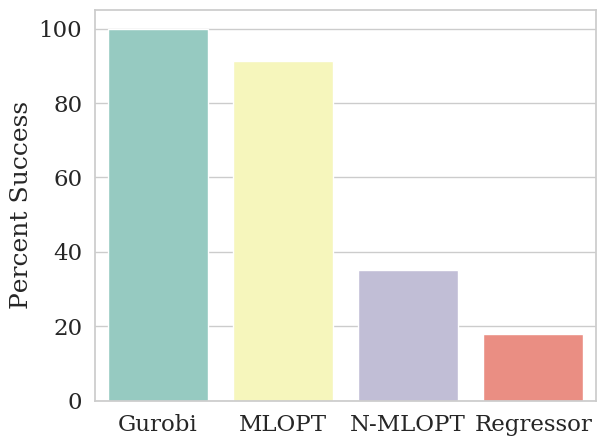

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[80]:4
└ @ Core In[80]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[80]:4
└ @ Core In[80]:4


In [80]:
results = DataFrame()
results.Policy = [ "Gurobi","MLOPT", "N-MLOPT", "Regressor"]
results.Success = [mip_percentage, classifier_percentage, naive_classifier_percentage, regressor_percentage]

ax1 = sns.barplot(x=results[:Policy], y=results[:Success], palette="Set3")
ax1.set(xlabel="", ylabel="Percent Success")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax1.get_figure();
figure.savefig(string("plots/",system,"_percent_success.pdf"))

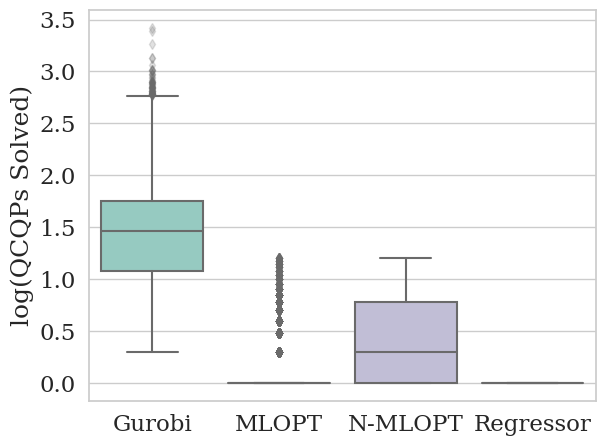

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[81]:9
└ @ Core In[81]:9
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[81]:9
└ @ Core In[81]:9


In [81]:
results = DataFrame()
results.Policy = vcat(fill("Gurobi", length(num_solves_IP)),
                        fill("MLOPT", length(num_solves_classifier)),
                        fill("N-MLOPT", length(num_solves_naive_classifier)),
                        fill("Regressor", length(num_solves_regressor)))
results.Solves = vcat(log10.(num_solves_IP.+1), log10.(num_solves_classifier), log10.(num_solves_naive_classifier), log10.(num_solves_regressor))

flierprops = Dict("alpha"=>0.2)
ax2 = sns.boxplot(x=results[:Policy], y=results[:Solves], palette="Set3", flierprops=flierprops)
ax2.set(xlabel="", ylabel="log(QCQPs Solved)")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax2.get_figure()
figure.savefig(string("plots/",system,"_solved.pdf"));

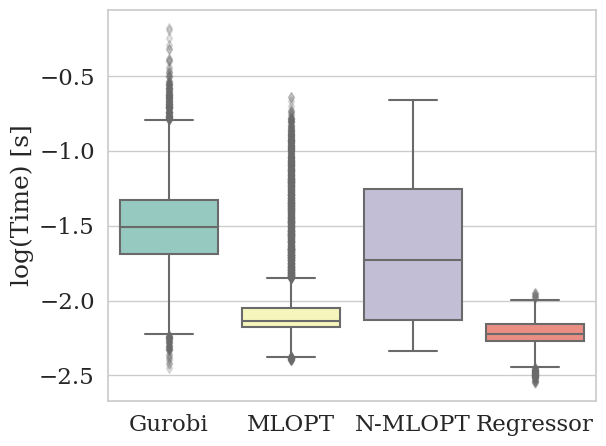

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[82]:9
└ @ Core In[82]:9
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[82]:9
└ @ Core In[82]:9


In [82]:
results = DataFrame()
results.Policy = vcat(fill("Gurobi", length(solve_times_IP)),
                        fill("MLOPT", length(solve_times_classifier)),
                        fill("N-MLOPT", length(solve_times_naive_classifier)),
                        fill("Regressor", length(solve_times_regressor)))
results.Time = vcat(log10.(solve_times_IP), log10.(solve_times_classifier), log10.(solve_times_naive_classifier), log10.(solve_times_regressor))

flierprops = Dict("alpha"=>0.2)
ax3 = sns.boxplot(x=results[:Policy], y=results[:Time], palette="Set3", flierprops=flierprops)
ax3.set(xlabel="", ylabel="log(Time) [s]")
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax3.get_figure();
figure.savefig(string("plots/",system,"_time.pdf"));

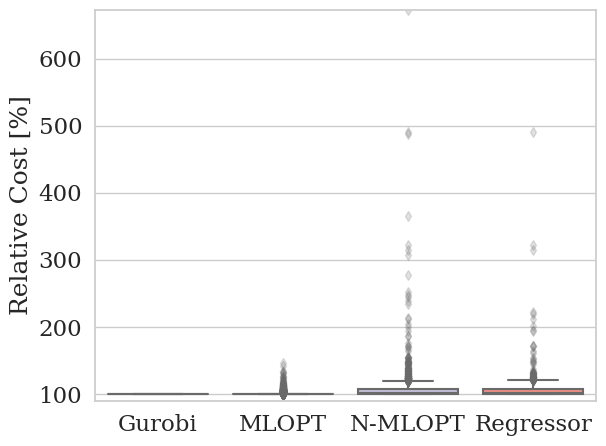

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[83]:9
└ @ Core In[83]:9
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[83]:9
└ @ Core In[83]:9


In [83]:
results = DataFrame()
results.Policy = vcat("Gurobi",
                        fill("MLOPT", length(costs_ratios_classifier)),
                        fill("N-MLOPT", length(costs_ratios_naive_classifier)),
                        fill("Regressor", length(costs_ratios_regressor)))
results.Costs = 100 .* [1; costs_ratios_classifier; costs_ratios_naive_classifier; costs_ratios_regressor]

flierprops = Dict("alpha"=>0.2)
ax4 = sns.boxplot(x=results[:Policy], y=results[:Costs], palette="Set3", flierprops=flierprops)
ax4.set(xlabel="", ylabel="Relative Cost [%]", ylim=(90,100*maximum([costs_ratios_classifier;costs_ratios_naive_classifier;costs_ratios_regressor])))
# PyPlot.gcf().subplots_adjust(left=0.15)
PyPlot.tight_layout()

figure = ax4.get_figure();
figure.savefig(string("plots/",system,"_cost.pdf"));

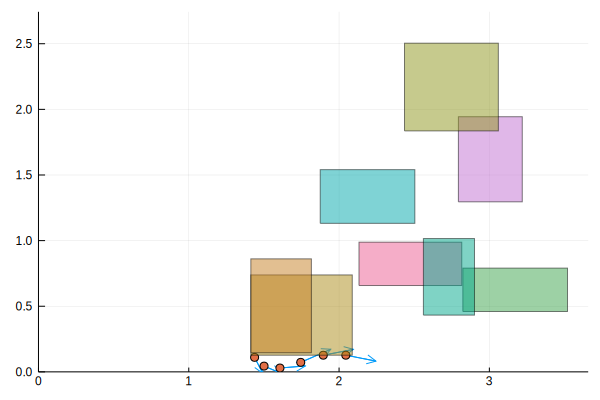

In [57]:
dir_idx = rand(training_batch_length+1:length(prob_dicts))
prob_idx = rand(1:length(prob_dicts[dir_idx]["Y"]))
prob = prob_handle(prob_dicts[dir_idx], prob_idx; optimizer=Mosek.Optimizer, verbose=false)[1]
optimize!(prob)

X_traj = prob_dicts[dir_idx]["X"][prob_idx]
obs = prob_dicts[dir_idx]["O"][prob_idx]

ft2m = 0.3048
posmax = ft2m*[12.,9.]
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

Plots.quiver(X_traj[1,:], X_traj[2,:], gradient=(X_traj[3,:], X_traj[4,:]))
Plots.scatter!(X_traj[1,:], X_traj[2,:])
for oo in obs[1:end-1]
    Plots.plot!(rectangle(oo[1][2]-oo[1][1],oo[2][2]-oo[2][1],oo[1][1], oo[2][1]), opacity=0.5, legend=false)
end
oo = obs[end]
Plots.plot!(rectangle(oo[1][2]-oo[1][1],oo[2][2]-oo[2][1],oo[1][1], oo[2][1]), opacity=0.5, legend=false,
    xaxis=("", (0,posmax[1])),yaxis=("", (0,posmax[2])))

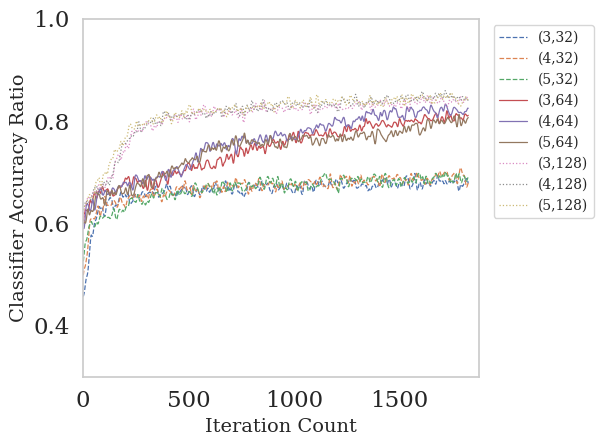

In [73]:
using HDF5
fn = "$system/batch_search.h5"

function lpf(data)
    len = length(data)
    data_lpf = zeros(len-2)
    for ii in 2:len-1
        data_lpf[ii-1] = 1/3 * (data[ii-1]+data[ii]+data[ii+1])
    end
    data_lpf
end

output = h5open(fn, "r") do file
    read(file, "batch_results")
end

batch_results = Dict()
batch_results_lpf = Dict()
for col in Base.eachcol(output)
    batch_results[(Int(col[1]),Int(col[2]))] = (1:length(col[3:end]), col[3:end])
    
    data_lpf = col[3:end]
    for ii in 1:25
        data_lpf = lpf(data_lpf)
    end
    batch_results_lpf[(Int(col[1]),Int(col[2]))] = (1:length(data_lpf), data_lpf)
end
batch_results;

markers = filter((m->begin
                m in Plots.supported_markers()
            end), Plots._shape_keys)

styles = filter((s->begin
                s in Plots.supported_styles()
            end), [:solid, :dash, :dot, :dashdot, :dashdotdot]);

last_val = nothing
marker_shapes = [:+, :circle, :vline, :hline, :x, :+, :vline, :hline]
line_styles = [:dash, :dot, :solid, :dashdot, :dash, :dot, :solid, :dashdot]
line_styles = ["--"; "-"; ":"; "-."]

ct = 0
for neurons in [32;64;128]
    ct += 1
    for depth in 3:5
        batch_results[(depth,neurons)]
        PyPlot.plot(batch_results_lpf[(depth,neurons)][1], batch_results_lpf[(depth,neurons)][2], label="($depth,$neurons)", 
            linestyle=line_styles[ct], linewidth=0.9)
    end
end

PyPlot.yticks(0:0.2:1)
PyPlot.ylim(0.3,1.)
PyPlot.ylabel("Classifier Accuracy Ratio", fontsize=14)

PyPlot.xticks(0:500:size(output,1)-2)
PyPlot.xlim(0.,size(output,1)-2)
PyPlot.xlabel("Iteration Count", fontsize=14)

PyPlot.legend(bbox_to_anchor=(1.02,1.),prop=Dict("size"=>10))
PyPlot.tight_layout()
PyPlot.grid(false)
PyPlot.savefig(string("plots/",system,"_batch_search.pdf"))